In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import wlcave as wlcave #need to path correctly!

## Import Files From Simulation:

In [2]:
file = "C:\\users/Thomas/wlcsim_membrane/data/2.10.21_NoInteractions_2hrs_r11v0.txt"
data = np.loadtxt(file) #D:\\myfiles\welcome.txt


## Our Approach to Calculating Percolation Paths Through a Polymer Membrane:

### Defining The System:

In our system we have random copolymers with solvent molecules. Polymers are represented by beads of types 1 and 2 and solvent molecules are individual beads of type 0. No bead can overlap another. 

### Defining Percolation:

A percolation is a pathway through the polymer network that solvent molecules can move through. To form a percolation a solvent molecule will need to have at least one other solvent molecule adjacent to it within some path radius $r$

### What are we trying to learn from the system:

The goal in developing this code is to determine quantitatively the amount of percolation in a membrane. 

### Models for Percolation:
**1. Fire Spread Model:** In this model we measure the percolation paths by tracing the spots where the solvent molecules continue to be adjacent to the previous... It's easier to explain with a picture

## What we need to calculate:

Starting with the final equilibrium state we have x,y,z postion of a bead and it's identity (and also methylation state). We want to calculate percolation paths which will be represented by root mean square. 

#### What Percolation Model do we want to use:

1. Fire spead model:

Proceedure:
1. Pick a bead type
2. pick a random bead of that bead type
3. Check surround bead types to see if they are the same
    a. Pick a radius to search in


# Note: for some reason if you declare two different PolymerNetworks, they can interfere w/ each other (change values)

In [3]:
def generate_test_data(length=10,width=10,height=10,datapoints=500):
    X = np.random.random(datapoints)*length
    Y = np.random.random(datapoints)*width
    Z = np.random.random(datapoints)*height
    Beads = np.random.randint(3,size=(datapoints)).astype('uint8')
    Beads
    return X,Y,Z,Beads

#generate_test_data()

In [4]:
class Bead:
    '''
    '''
    def __init__(self, x, y, z, bead_type):
        self.x = x
        self.y = y
        self.z = z
        self.bead_type = bead_type
        


In [5]:
class Polymer:
    '''
    '''
    
    def __init__(self, bead_list):
        self.bead_list = bead_list
    
    def print_bead_list(self):
        for i, bead in enumerate(self.bead_list):
            print("Bead " + str(i) + ": " + str(bead.x) + ", " + str(bead.y) + ", " + str(bead.z) + " Type: " + str(bead.bead_type))
   

In [6]:
class PolymerNetwork:
    """
    This represents the postions of bead and their type (time invariant)
    
    Parameters
    ----------
    X : float [array] X 
    """
    
    def __init__(self,X,Y,Z, Beads, beads_per_polymer=40, persistence_length=2.03, bead_list=[], polymer_list=[]):
        self.X = X
        self.Y = Y
        self.Z = Z
        self.Beads = Beads
        self.beads_per_polymer = beads_per_polymer
        self.bead_list = bead_list
        self.polymer_list = polymer_list
        self.persistence_length = persistence_length
        
        self.density = Beads.shape[0]/((max(X)-min(X)) * (max(Y)-min(Y)) * (max(Z)-min(Z)))
        
    def visualize(self):
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(self.X[Beads==0], self.Y[Beads==0], self.Z[Beads==0],color='y')
        ax.scatter3D(self.X[Beads==1], self.Y[Beads==1], self.Z[Beads==1],color='r')
        ax.scatter3D(self.X[Beads==2], self.Y[Beads==2], self.Z[Beads==2],color='b')
        
    def nearest_neighbor(self,bead_num,radius):
        '''
        Find the average number of beads that surround a bead of the same type within the radius specified
        '''
        X_bead = self.X[Beads==bead_num]
        Y_bead = self.Y[Beads==bead_num]
        Z_bead = self.Z[Beads==bead_num]
        
        total_neighbors = 0
        for i in range(Beads[Beads==bead_num].shape[0]):
            point = np.array([X_bead[i],Y_bead[i],Z_bead[i]])
            displacement = np.sqrt((X_bead - point[0])**2 + (Y_bead - point[1])**2 + (Z_bead - point[2])**2)
            num_neighbor_points = displacement[displacement<=radius].shape[0] -1
            
            total_neighbors += num_neighbor_points

        return total_neighbors/(i+1)
    
    def create_beads(self):
        if len(self.bead_list) != 0:
            raise Exception("bead list already populated")
        for i in range(len(self.X)):
            bead = Bead(self.X[i], self.Y[i], self.Z[i], self.Beads[i])
            self.bead_list.append(bead)
    
    def print_bead_list(self):
        for i, bead in enumerate(self.bead_list):
            print("Bead " + str(i) + ": " + str(bead.x) + ", " + str(bead.y) + ", " + str(bead.z) + " Type: " + str(bead.bead_type))
    
    def create_polymers(self):
        if len(self.polymer_list) != 0:
            raise Exception("polymer list already populated")
        if len(self.bead_list) == 0:
            raise Exception("Need to run create_beads before create_polymers")
        for i in range(self.beads_per_polymer, len(self.bead_list) + 1, self.beads_per_polymer):
            polymer = Polymer(self.bead_list[i - self.beads_per_polymer : i])
            self.polymer_list.append(polymer)
        
    def print_polymer_list(self, verbose=False):
        for i, poly in enumerate(self.polymer_list):
            print("POLYMER " + str(i))
            if verbose:
                poly.print_bead_list()

In [7]:
'''
Determine the mean square interbead distance
Input: PolymerNetwork
       int skip_parameter: ratio of how many non-overlapping jumps of size d to skip when calculating the mean square 
       displacemnt between two beads distance d away. 1 means include all non-overlapping jumps,
       2 means every other, 3 means every third, etc.
Return: A DataFrame where the columns are a specific polymer in the network, rows are the number of "jumps" n,
        and the values are the average distance squared bewteen beads n jumps away (averaged over all different jumps 
        of size n possible in the polymer)
     <R^2> array of mean square end-to-end distances for all polymers with 0 to num_beads - 1 bonds
     non-dimensionalized by (2*l_p)^2
'''
def r2(polymer_network, skip_parameter=1):
    if len(polymer_network.bead_list) == 0:
        raise Exception("Need to run create_beads")
    if len(polymer_network.polymer_list) == 0:
        raise Exception("Need to run create_polymers")
    num_poly = len(polymer_network.polymer_list)
    avg_n_jumps = pd.DataFrame(index=range(polymer_network.beads_per_polymer), columns=range(num_poly))
    
    for i, poly in enumerate(polymer_network.polymer_list):
        # creating matrix of (inter-bead distances)^2 for a given polymer
        bead_dist = create_polymer_r2_table(poly)
        
        # get diagonals (non-overlapping jumps of size 0 - all beads), avg, store in the dataframe
        avg_n_jumps[i] = get_avg_jump_distances(poly, bead_dist, skip_parameter)
        
        if (i % 500 == 0):
            print("processed polymer " + str(i))
    
    #average the distance b/w chain ends, normailize (???)
    num_beads = polymer_network.beads_per_polymer
    r2_ave_vect = np.zeros(num_beads)
    for i in range(num_beads):
        row_avg = np.average(avg_n_jumps.iloc[i]) # average size i jump over all polymers
        r2_ave_vect[i] = row_avg
    
    #print("r2_ave before normalization = " + str(np.average(avg_n_jumps.iloc[num_beads-1])))
    #r2_ave = np.average(avg_n_jumps.iloc[num_beads-1])/(2 * polymer_network.persistence_length)**2
    
    return r2_ave_vect, avg_n_jumps

'''
Creates a 2D array with the square distance from each bead to each other bead in a polymer.
Inputs: Polymer class
Returns: 2D array of square distances
'''
def create_polymer_r2_table(polymer):
    num_beads = len(polymer.bead_list)
    bead_dist = np.zeros((num_beads, num_beads))    
    for j, bead1 in enumerate(polymer.bead_list):
        for k, bead2 in enumerate(polymer.bead_list):
            position1 = np.array([bead1.x, bead1.y, bead1.z])
            position2 = np.array([bead2.x, bead2.y, bead2.z])
            displacement_squared = np.sum((position2 - position1)**2)
            bead_dist[j][k] = displacement_squared
    return bead_dist

'''
Given a 2D array of square bead displacements, this function finds the average square distance of all 
non overlapping jumps, for all possible jump sizes. 
Inputs: Polymer
        polymer_bead_dist- 2D array of bead square displacements
        skip_parameter- ratio of how many non-overlapping jumps of size d to skip. 1 means include all non-overlapping
        jumps, 2 means every other, 3 means every third, etc.
Returns: n_jump_dist_avg- a 1D array where the index i corresponds to the average square displacement of a jump size i
'''
def get_avg_jump_distances(polymer, polymer_bead_dist, skip_parameter):
    num_beads = len(polymer.bead_list)
    n_jump_dist_avg = np.zeros(num_beads)
    for d in range(num_beads):   # for all jump sizes
            diag = np.diag(polymer_bead_dist, d) # get jumps of size d
            if d == 0:
                n_jump_dist_avg[d] = np.average(diag)
            else:
                n_jump_dist_avg[d] = np.average(diag[::skip_parameter*d])  # average all non-overlapping jumps
    return n_jump_dist_avg    

In [8]:
#TEST DATA:

#X,Y,Z,Beads = generate_test_data()
#PNet_Test = PolymerNetwork(X,Y,Z,Beads, beads_per_polymer = 10)
#PNet_Test.create_beads()
#PNet_Test.create_polymers()
#PNet_Test.density

In [9]:
#PNet_Test.visualize()

In [10]:
#PNet_Test.nearest_neighbor(bead_num=0,radius=0.4)

In [11]:
#radii = np.linspace(0,15,100)
#for r in radii:
#    plt.plot(r,PNet_Test.nearest_neighbor(bead_num=0,radius=r),'y.')
#plt.xlabel('Radius')
#plt.ylabel('Average Number of Neighbor Points')

In [12]:
#x = r2(PNet_Test)
#x  # roughly random dist (no polymer chain)

In [13]:
#REAL DATA:

beads = np.zeros(len(data[:, 0]))   # no chemical identity data
no_interactions = PolymerNetwork(data[:, 0], data[:, 1], data[:, 2], beads, beads_per_polymer=40)

In [14]:
no_interactions.create_beads()
#no_interactions.print_bead_list()
len(no_interactions.bead_list)  # should be 80,000

80000

In [15]:
no_interactions.create_polymers()
#no_interactions.print_polymer_list(verbose=True)
print(len(no_interactions.polymer_list)) #should be 2000


2000


In [16]:
#no_interactions.visualize()  #too many beads?

In [17]:
r2_ave_vect, result = r2(no_interactions)

processed polymer 0
processed polymer 500
processed polymer 1000
processed polymer 1500


In [18]:
print(r2_ave_vect)
result 

[ 0.          0.16151278  0.59243728  1.24522628  2.07954993  3.06723617
  4.16569789  5.38538837  6.6487218   7.99208484  9.43793932 10.91659667
 12.37818563 13.89308667 15.4362178  17.04347128 18.64487326 20.22891804
 21.86025942 23.50434944 24.94745151 26.62523187 28.29599453 29.94128328
 31.55428672 33.20252514 34.84755739 36.54806549 38.21162255 39.91101385
 41.60153843 43.23246742 44.83438119 46.43516301 48.01264577 49.62889591
 51.19779563 52.80529516 54.39301144 56.05036629]


,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.157959,0.147473,0.162123,0.171162,0.162561,0.162067,0.161183,0.154522,0.170941,0.160492,...,0.151643,0.160275,0.164059,0.162455,0.164502,0.158164,0.166980,0.166170,0.167712,0.165205
2,0.574533,0.549160,0.584291,0.626571,0.616642,0.601353,0.595330,0.565054,0.620521,0.593195,...,0.551825,0.585822,0.610149,0.601800,0.609381,0.566848,0.625966,0.593470,0.630145,0.595209
3,1.155976,1.179395,1.214368,1.318761,1.276532,1.260369,1.230608,1.188685,1.311302,1.233289,...,1.217028,1.286766,1.291160,1.268626,1.297717,1.218394,1.254425,1.288799,1.303457,1.255706
4,2.002388,1.891087,2.092197,2.065103,2.271605,2.145827,2.012835,1.760094,2.125436,2.012604,...,1.989987,2.051770,2.246046,2.029045,2.312009,2.095656,2.166242,2.149006,2.363098,1.950021
5,2.718192,2.596062,2.963646,3.143028,3.352720,3.179280,2.946224,2.635450,3.060645,2.772549,...,3.017031,3.008510,3.284773,3.197441,3.237589,2.838998,2.926162,3.253156,3.167626,2.635641
6,3.841749,3.502546,4.018099,4.069769,4.222490,4.509687,3.687525,3.610766,4.294624,3.938173,...,4.040649,3.386335,4.564999,4.418388,4.731706,3.881189,3.829188,3.867371,4.363755,3.849555
7,5.468836,3.956770,5.277126,4.600353,5.480911,5.530452,5.266811,4.162948,5.190584,4.970776,...,5.364221,5.052126,5.778548,5.732843,6.450962,5.051290,6.144148,5.324831,6.092218,4.531792
8,6.759105,5.748485,7.181959,5.340157,6.071908,6.127135,6.328008,5.391625,6.886879,6.510991,...,7.253022,5.963385,6.944149,7.423521,8.355813,6.506519,7.374955,7.837888,6.254794,4.540583
9,7.181217,6.738717,6.911374,8.573450,8.030048,8.277606,7.343234,7.277459,7.836084,7.823021,...,9.385375,6.737436,8.080345,7.645197,9.727783,8.614129,8.895220,7.710424,7.497201,5.639447


In [19]:
#wlc: kuhn length b ~= 2 * persistence length
kuhn_l = 2 * no_interactions.persistence_length
print(kuhn_l)

4.06


[ 0.          0.16151278  0.59243728  1.24522628  2.07954993  3.06723617
  4.16569789  5.38538837  6.6487218   7.99208484  9.43793932 10.91659667
 12.37818563 13.89308667 15.4362178  17.04347128 18.64487326 20.22891804
 21.86025942 23.50434944 24.94745151 26.62523187 28.29599453 29.94128328
 31.55428672 33.20252514 34.84755739 36.54806549 38.21162255 39.91101385
 41.60153843 43.23246742 44.83438119 46.43516301 48.01264577 49.62889591
 51.19779563 52.80529516 54.39301144 56.05036629]
sim chain lenghts:  [1.07793783 1.37896783 1.55505909 1.67999782 1.77690784 1.85608908
 1.92303587 1.98102782 2.03218034 2.07793783 2.11933052 2.15711908
 2.19188118 2.22406587 2.25402909 2.28205781 2.30838675 2.33321034
 2.35669143 2.37896783 2.40015713 2.42036051 2.43966567 2.45814907
 2.47587784 2.49291118 2.5093016  2.52509586 2.54033583 2.55505909
 2.56929952 2.58308781 2.59645177 2.60941675 2.62200588 2.63424033
 2.64613956 2.65772143 2.66900244]
sim r2 vals:  [-0.79179311 -0.22735762  0.09524828  0.3

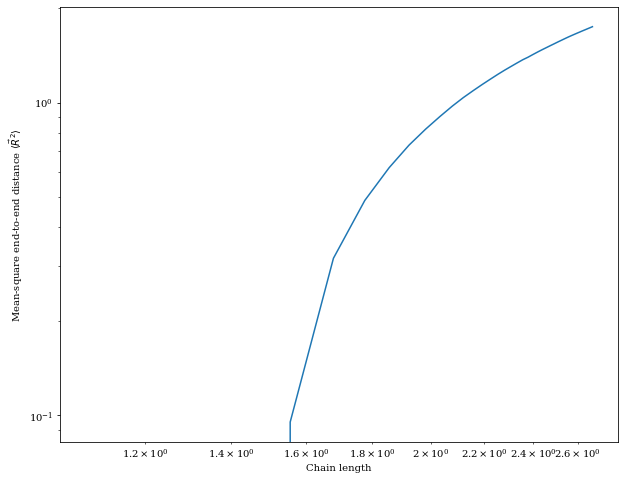

In [44]:
print(r2_ave_vect)
sim_r2_vals = np.log10(r2_ave_vect[1:])
bead_spacing = 16.26/39 # WLC_P__L polymer length / WLC_P_NB - 1 num beads - 1. in simulation units 
#
#BEAD SPACING DOESN'T MATCH AVG 1 JUMP :( 
#
bead_spacing_nm = bead_spacing * 28.7 # 1 simulation unit = 28.7 nm

sim_chain_lengths = np.zeros(39)

for i in range(1, 40):
    sim_chain_lengths[i-1] = bead_spacing_nm * i

sim_chain_lengths = np.log10(sim_chain_lengths)
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 10}
plt.rc('font', **font)
plt.loglog(sim_chain_lengths, sim_r2_vals)
print("sim chain lenghts: ", sim_chain_lengths)
print("sim r2 vals: ", sim_r2_vals)
#plt.loglog(length_kuhn[0:60], rg2short[0:60])        # Short length asymptotic solution
#plt.loglog(length_kuhn[40:100], rg2long[40:100]) # Long length asymptotic solution
plt.xlabel(r'Chain length')# $N = L/(2l_{p})$')
plt.ylabel(r'Mean-square end-to-end distance $\langle \vec{R}^{2} \rangle$')
#plt.tight_layout()
plt.show()

'''
ISSUES:
Bead spacing doesn't match the avg 1 bond jump

negative log(r2) vals ??

not log on x axis
'''

In [33]:
wlcave.r2_ave(kuhn_l, 3)

3.5601487643302203

Not = to 3.4  :|

Plot the number of beads/size of jumps (row index) vs avg displacement squared (average of row) ?

In [22]:
# idea: find mak disp square per polymer, avg all of those ot ger r^2